In [2]:
import matplotlib.pyplot as plt
import numpy as np

from commpy.modulation import QAMModem

from optic.dsp import pulseShape, firFilter, decimate, symbolSync, resample
from optic.models import phaseNoise, KramersKronigRx, linFiberCh, photodiode

from optic.tx import simpleWDMTx
from optic.core import parameters
from optic.equalization import edc, mimoAdaptEqualizer
from optic.carrierRecovery import cpr
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power
from optic.plot import pconst

import scipy.constants as const
from tqdm.notebook import tqdm

### Simulation of a single polarization optical signal transmission

In [19]:
## Transmitter parameters:
paramTx = parameters()
paramTx.M = 16                 # order of the modulation format
paramTx.Rs = 32e9              # symbol rate [baud]
paramTx.SpS = 4                # samples per symbol
paramTx.Nbits = 400000         # total number of bits per polarization
paramTx.pulse = "rrc"          # pulse shaping filter
paramTx.Ntaps = 1024           # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01        # RRC rolloff
paramTx.Pch_dBm = 0            # power of the optical signal [dBm]
paramTx.Nch = 1                # number of WDM channels
paramTx.Fc = 193.1e12          # central frequency of the optical spectrum
paramTx.freqSpac = 37.5e9      # WDM grid spacing

## Optical channel parameters:
Ltotal = 0      # total link distance [km]
alpha = 0        # fiber loss parameter [dB/km]
D = 16          # fiber dispersion parameter [ps/nm/km]
Fc = paramTx.Fc  # central optical frequency of the WDM spectrum [Hz]

## Receiver parameters:

# local oscillator (LO)
FO = 5e9 + paramTx.Rs/2  # frequency offset
lw = 0*200e3       # linewidth
ϕ_lo = 0           # initial phase in rad
Plo_dBm = 12       # power in dBm

# ADC sampling rate
paramADC = parameters()
paramADC.Rs = paramTx.Rs
paramADC.SpS_in = paramTx.SpS
paramADC.SpS_out = 4

## General simulation parameters:
chIndex = 0  # index of the channel to be demodulated
plotPSD = True
Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

# photodiode parameters
paramPD = parameters()
paramPD.B  = 1.1*paramTx.Rs
paramPD.Fs = Fs

### Core simulation code

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


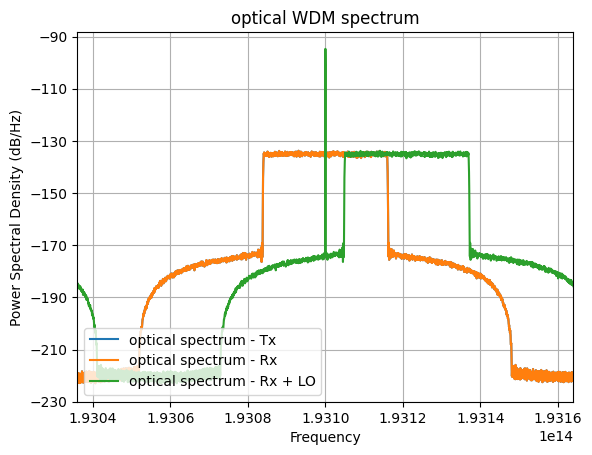

In [20]:
# generate optical signal signal
sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

# simulate linear signal propagation
sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)

# plots optical spectrum before and after transmission

# before
plt.figure()
plt.xlim(paramTx.Fc - Fs / 2, paramTx.Fc + Fs / 2)
plt.psd(
    sigTx[:, 0],
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Tx",
)

# after
plt.psd(
    sigCh,
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Rx",
)
plt.legend(loc="lower left")
plt.title("optical spectrum")

# receiver detection and demodulation

Fc = paramTx.Fc
Ts = 1 / Fs
mod = QAMModem(m=paramTx.M)

freqGrid = paramTx.freqGrid
print(
    "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
    % (
        chIndex,
        (Fc + freqGrid[chIndex]) / 1e12,
        const.c / (Fc + freqGrid[chIndex]) / 1e-9,
    )
)

symbTx = symbTx_[:, :, chIndex]

Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

print(
    "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
    % (Plo_dBm, lw / 1e3, FO / 1e6)
)

# generate LO field
π = np.pi
t = np.arange(0, len(sigCh))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

# Add LO to the received signal
sigRx = np.sqrt(Plo) + sigCh* np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
sfm   = sigRx.copy()

print('CSPR = %.2f dB'%(10*np.log10(signal_power(sigLO)/signal_power(sigCh))))

# plot spectrum fter adding LO
plt.psd(
    sigRx,
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Rx + LO",
)
plt.legend(loc="lower left")
plt.title("optical WDM spectrum");

### Phase-retrieval stage

SIR =  23.86  dB


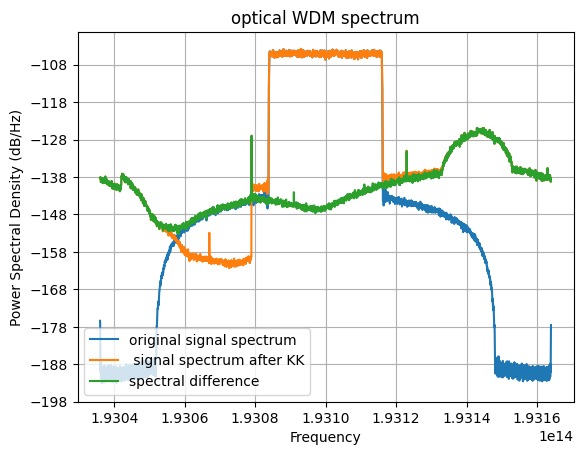

In [21]:
# simulate ideal direct-detection optical receiver
Ipd = photodiode(sigRx, paramPD)
Amp = np.sqrt(Ipd)
Amp = resample(Amp, paramADC)

# resampling to ADC sampling rate
sigCh = resample(sigCh, paramADC)
sfm = resample(sfm, paramADC)
newFs = paramADC.SpS_out*paramTx.Rs

# Kramers-Kronig phase-retrieval
phiTime = KramersKronigRx(Amp, newFs)

# optical field reconstruction
sigRx = Amp*np.exp(1j*phiTime)
sfm_KK = sigRx.copy()

# remove DC level
sigRx -= np.sqrt(Plo)  # np.mean(sigRx)

# downshift to baseband
t = np.arange(0, len(sigRx))*(1/newFs)
sigRx *= np.exp(-1j * (2 * π * FO * t))

# plot spectrum of  the reconstructed field

# plot spectrum of  the reconstructed field
plt.psd(
    sigCh/np.sqrt(signal_power(sigCh)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="original signal spectrum",
)

plt.psd(
    sigRx/np.sqrt(signal_power(sigRx)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label=" signal spectrum after KK",
)

# correct for (possible) phase ambiguity
rot = np.mean(sigCh/sigRx)
sigRx = rot * sigRx
sigRx = sigRx / np.sqrt(signal_power(sigRx))

# plot spectrum of  the reconstructed field
plt.psd(
    sigRx/np.sqrt(signal_power(sigRx))-sigCh/np.sqrt(signal_power(sigCh)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="spectral difference",
)
plt.legend(loc="lower left")
plt.title("optical WDM spectrum");

# calculate interference
intf = sigRx/np.sqrt(signal_power(sigRx))-sigCh/np.sqrt(signal_power(sigCh))

SIR = 1/signal_power(intf)

print('SIR = ', round(10*np.log10(SIR),2), ' dB')

#### Standard receiver processing

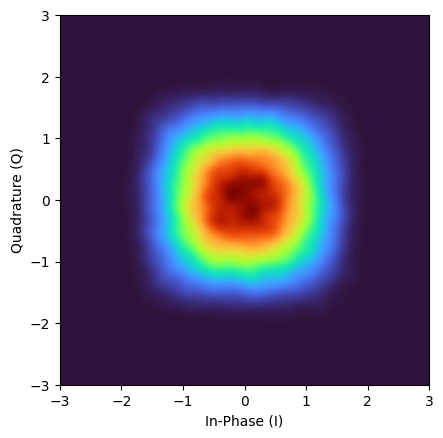

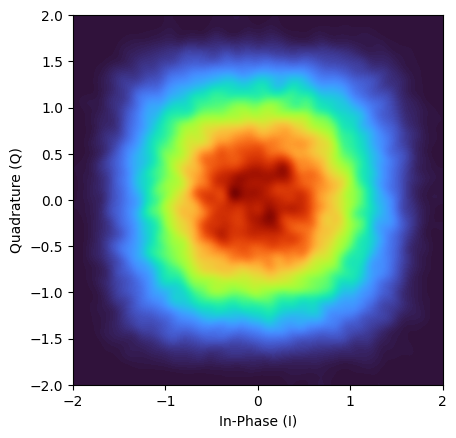

In [22]:
# resample to 2 samples/symbol:
paramRes = parameters()
paramRes.Rs = paramTx.Rs
paramRes.SpS_in = paramADC.SpS_out
paramRes.SpS_out = 2

sigRx = resample(sigRx, paramRes)

# Matched filtering and CD compensation

# Matched filtering
if paramTx.pulse == "nrz":
    pulse = pulseShape("nrz", paramADC.SpS_out)
elif paramTx.pulse == "rrc":
    pulse = pulseShape(
        "rrc", paramRes.SpS_out, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1 / paramTx.Rs
    )

pulse = pulse / np.max(np.abs(pulse))
sigRx = firFilter(pulse, sigRx)

# plot constellations after matched filtering
pconst(sigRx[0::paramRes.SpS_out], lim=True, R=3)

# CD compensation
sigRx = edc(sigRx, Ltotal, D, Fc, paramRes.SpS_out*paramTx.Rs)

#plot constellations after CD compensation
pconst(sigRx[0::paramRes.SpS_out], lim=True, R=2)

# Downsampling to 2 sps and re-synchronization with transmitted sequences
sigRx = sigRx.reshape(-1, 1)

symbRx = symbolSync(sigRx, symbTx, 2)

  0%|          | 0/5 [00:00<?, ?it/s]

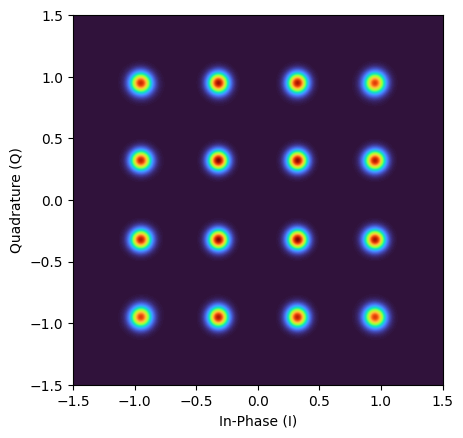

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [23]:
# Power normalization
x = sigRx
d = symbRx

x = x.reshape(len(x), 1) / np.sqrt(signal_power(x))
d = d.reshape(len(d), 1) / np.sqrt(signal_power(d))

# Adaptive equalization
mod = QAMModem(m=paramTx.M)

paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS = 2
paramEq.mu = [5e-3, 2e-3]
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.alg = ["nlms", "dd-lms"]
paramEq.M = paramTx.M
paramEq.L = [20000, 80000]

y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

discard = int(paramEq.L[0]/2)

#plot constellations after adaptive equalization
pconst(y_EQ[discard:-discard, :], lim=True)

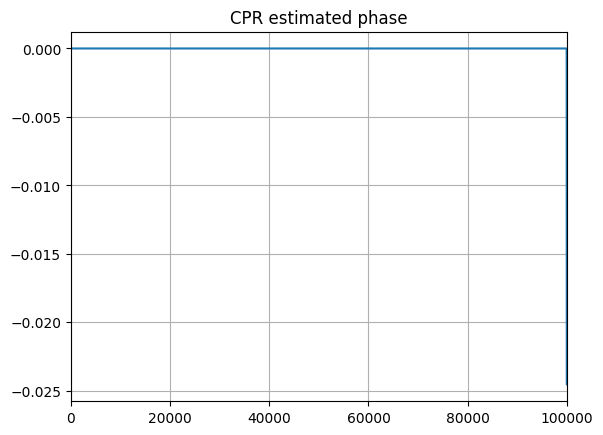

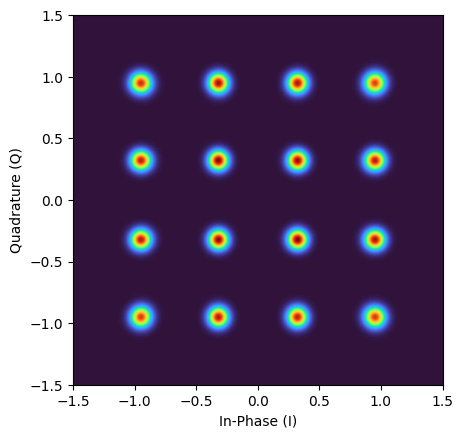

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [24]:
# Carrier phase recovery
paramCPR = parameters()
paramCPR.alg = "bps"
paramCPR.M = paramTx.M
paramCPR.N = 75
paramCPR.B = 64
paramCPR.pilotInd = np.arange(0, len(y_EQ), 20)

y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

plt.figure()
plt.title("CPR estimated phase")
plt.plot(θ, "-")
plt.xlim(0, len(θ))
plt.grid()

discard = 5000

# plot constellations after CPR
pconst(y_CPR[discard:-discard, :], lim=True)


#### Evaluate transmission metrics

In [25]:
# correct for (possible) phase ambiguity
for k in range(y_CPR.shape[1]):
    rot = np.mean(d[:, k] / y_CPR[:, k])
    y_CPR[:, k] = rot * y_CPR[:, k]

y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

ind = np.arange(discard, d.shape[0] - discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind, :], d[ind, :], paramTx.M, 'qam')
GMI, _ = monteCarloGMI(y_CPR[ind, :], d[ind, :], paramTx.M, 'qam')
MI = monteCarloMI(y_CPR[ind, :], d[ind, :], paramTx.M, 'qam')

print("Results:\n")
print("SER: %.2e" % (SER[0]))
print("BER: %.2e" % (BER[0]))
print("SNR: %.2f dB" % (SNR[0]))
print("MI: %.2f bits" % (MI[0]))
print("GMI: %.2f bits" % (GMI[0]));

Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 28.96 dB
MI: 4.00 bits
GMI: 4.00 bits


In [13]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1DTranspose, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.utils.vis_utils import plot_model

## Neural network training

C:\Users\optic\AppData\Local\Temp\ipykernel_3848\247006539.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  X_train[indPhase] = sigAmp[indPhase:N+indPhase]


Epoch 1/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0537 - val_loss: 0.0022
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 8.0217e-04 - val_loss: 0.0016
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.8853e-04 - val_loss: 9.6235e-04
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 4.9739e-04 - val_loss: 0.0010
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 4.3557e-04 - val_loss: 4.3594e-04
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 4.0577e-04 - val_loss: 3.1229e-04
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 3.8760e-04 - val_loss: 4.9472e-04
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 3.4434e-04 - val_loss: 2.0857e-04
Epoch 9/100
1094/1094 [==============================] - 3s 2ms/step - loss: 3.3007e-04 - val_loss: 1.5621e-04
Epoch 10/100
1094

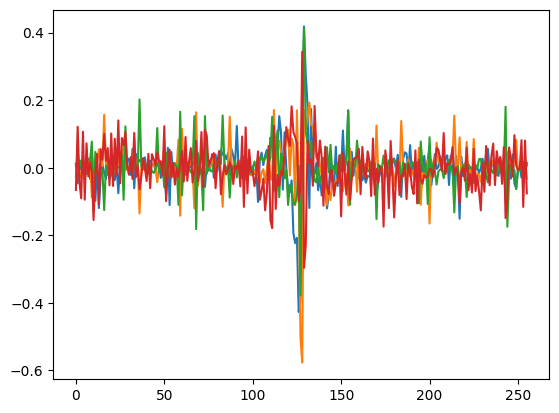

In [30]:
N = 256 # number of input amplitude samples to the NN

sfm = sfm/np.sqrt(signal_power(sfm))

sigPhase = np.angle(sfm) # get signal phase samples (labels) (L,)
sigAmp   = np.pad(Amp, (int(N/2), int(N/2)), 'constant') # get signal amplitude samples (L,)

# create set of input features
X_train = np.zeros((len(sigPhase), N)) #(L,N)

for indPhase in range(len(sigPhase)):
    X_train[indPhase] = sigAmp[indPhase:N+indPhase]

# create set of phase labels
y_train = np.array([sfm.real, sfm.imag]).T

# define neural network model
stop = EarlyStopping(monitor='val_loss', patience=5)
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(4, input_shape=(N,)))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=100, callbacks=[stop],
      validation_split=0.3, batch_size=256)

model.summary()

cw1 = model.layers[1].get_weights()
plt.plot(cw1[0]);

#model.save('NN_models/testModel_SpS_'+str(paramADC.SpS_out))

In [31]:
sfm_NN = model.predict(X_train)

12500/12500 [==============================] - 10s 779us/step


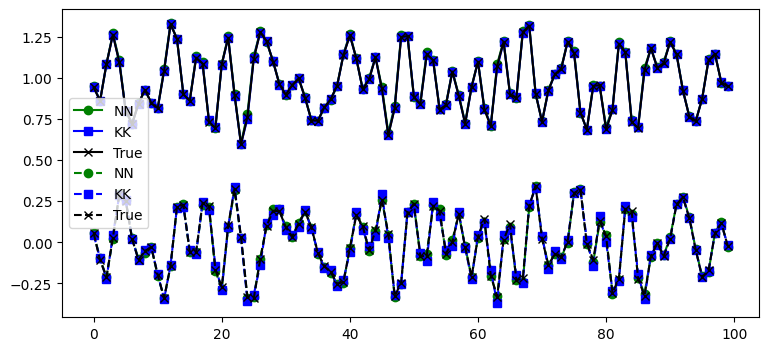

In [32]:
sfm_KK = sfm_KK/np.sqrt(signal_power(sfm_KK))
plt.figure(figsize=(9,4))
plt.plot(sfm_NN[300:400,0],'g-o',label='NN')
plt.plot(np.real(sfm_KK)[300:400],'b-s',label='KK')
plt.plot(np.real(sfm)[300:400],'k-x',label='True')

plt.plot(sfm_NN[300:400,1],'g--o',label='NN')
plt.plot(np.imag(sfm_KK)[300:400],'b--s',label='KK')
plt.plot(np.imag(sfm)[300:400],'k--x',label='True')
plt.legend();

In [34]:
N = np.array([32, 64, 128, 256, 512]) # number of input amplitude samples to the NN
MSE = np.zeros(N.size)

for indNN, indNN_ in enumerate(tqdm(N)):
    
    N = indNN_
    sfm = sfm/np.sqrt(signal_power(sfm))

    sigPhase = np.angle(sfm) # get signal phase samples (labels) (L,)
    sigAmp   = np.pad(Amp, (int(N/2), int(N/2)), 'constant') # get signal amplitude samples (L,)

    # create set of input features
    X_train = np.zeros((len(sigPhase), N)) #(L,N)

    for indPhase in range(len(sigPhase)):
        X_train[indPhase] = sigAmp[indPhase:N+indPhase]

    # create set of phase labels
    y_train = np.array([sfm.real, sfm.imag]).T

    # define neural network model
    stop = EarlyStopping(monitor='val_loss', patience=5)
    model = Sequential()
    model.add(BatchNormalization())
    model.add(Dense(4, input_shape=(N,)))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(2))
    model.compile(optimizer='adam', loss='mse')

    history = model.fit(X_train, y_train, epochs=100, callbacks=[stop], validation_split=0.3, batch_size=256)

    #model.save('ConvNets_models/convnet_model_SpS_'+str(paramTx.SpS), save_format='h5')
    mse_train  = np.mean(history.history['loss'])
    MSE[indNN] = mse_train

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\optic\AppData\Local\Temp\ipykernel_3848\4130199342.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  X_train[indPhase] = sigAmp[indPhase:N+indPhase]


Epoch 1/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0187 - val_loss: 7.6511e-04
Epoch 2/100
1094/1094 [==============================] - 2s 2ms/step - loss: 5.9083e-04 - val_loss: 3.1630e-04
Epoch 3/100
1094/1094 [==============================] - 2s 2ms/step - loss: 3.8090e-04 - val_loss: 2.0970e-04
Epoch 4/100
1094/1094 [==============================] - 2s 2ms/step - loss: 2.9910e-04 - val_loss: 1.1185e-04
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 2.5772e-04 - val_loss: 1.4295e-04
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 2.4505e-04 - val_loss: 1.4127e-04
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 2.2519e-04 - val_loss: 7.5141e-05
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 2.1806e-04 - val_loss: 8.8404e-05
Epoch 9/100
1094/1094 [==============================] - 2s 2ms/step - loss: 2.2825e-04 - val_loss: 1.5343e-04
Epoch

C:\Users\optic\AppData\Local\Temp\ipykernel_3848\3013751706.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--o" (-> color='k'). The keyword argument will take precedence.
  plt.plot(N, 20*np.log10(MSE), 'k--o', color='b', label='mlp training samples')


Text(0.5, 1.0, 'Sample Saturation Analysis')

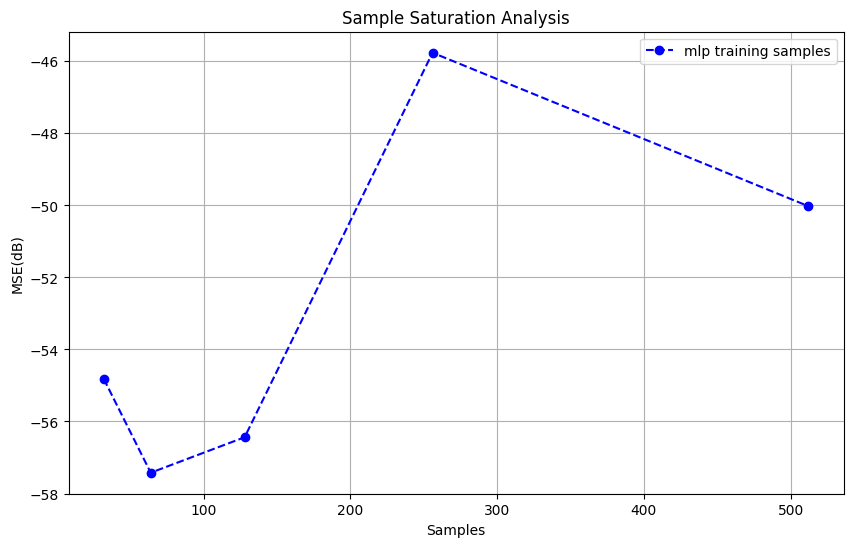

In [38]:
plt.figure(num=None, figsize=(10, 6))
plt.plot(N, 20*np.log10(MSE), 'k--o', color='b', label='mlp training samples')
plt.grid()
plt.legend()
plt.xlabel('Samples')
plt.ylabel('MSE(dB)')
plt.title('Sample Saturation Analysis')

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


C:\Users\optic\AppData\Local\Temp\ipykernel_3848\619573391.py:65: ComplexWarning: Casting complex values to real discards the imaginary part
  X_input[indPhase] = sigAmp[indPhase:N+indPhase]


12500/12500 [==============================] - 16s 1ms/step
SIR =  24.88  dB


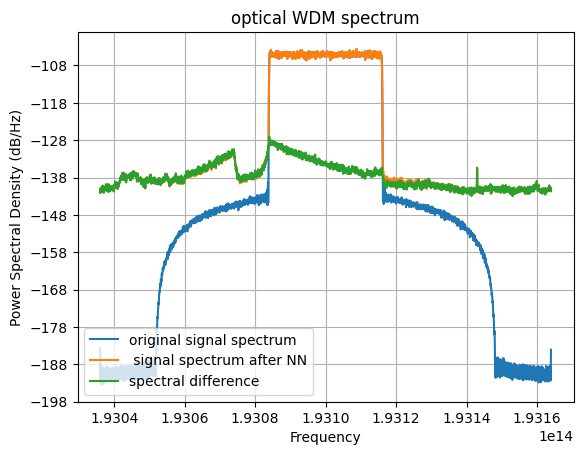

In [40]:
N = model.layers[1].get_weights()[0].shape[0]

# generate optical signal signal
sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

# simulate linear signal propagation
sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)

# receiver detection and demodulation
Fc = paramTx.Fc
Ts = 1 / Fs
mod = QAMModem(m=paramTx.M)

freqGrid = paramTx.freqGrid
print(
    "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
    % (
        chIndex,
        (Fc + freqGrid[chIndex]) / 1e12,
        const.c / (Fc + freqGrid[chIndex]) / 1e-9,
    )
)

symbTx = symbTx_[:, :, chIndex]

Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

print(
    "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
    % (Plo_dBm, lw / 1e3, FO / 1e6)
)

# generate LO field
π = np.pi
t = np.arange(0, len(sigCh))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

# Add LO to the received signal
sigRx = np.sqrt(Plo) + sigCh* np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
sfm   = sigRx.copy()

print('CSPR = %.2f dB'%(10*np.log10(signal_power(sigLO)/signal_power(sigCh))))

# simulate ideal direct-detection optical receiver
Ipd = photodiode(sigRx, paramPD)
Amp = np.sqrt(Ipd)
Amp = resample(Amp, paramADC)

# resampling to ADC sampling rate
sigCh = resample(sigCh, paramADC)
sfm = resample(sfm, paramADC)
newFs = paramADC.SpS_out*paramTx.Rs

sfm = sfm/np.sqrt(signal_power(sfm))

sigPhase = np.angle(sfm) # get signal phase samples (labels) (L,)
sigAmp   = np.pad(Amp, (int(N/2), int(N/2)), 'constant') # get signal amplitude samples (L,)

# create set of input features
X_input = np.zeros((len(sigPhase), N)) #(L,N)

for indPhase in range(len(sigPhase)):
    X_input[indPhase] = sigAmp[indPhase:N+indPhase]

sigRx_NN = model.predict(X_input)

# optical field reconstruction
sigRx = sigRx_NN[:,0]+1j*sigRx_NN[:,1]

# remove DC level
sigRx -= np.mean(sigRx) # np.sqrt(Plo)  

# downshift to baseband
t = np.arange(0, len(sigRx))*(1/newFs)
sigRx *= np.exp(-1j * (2 * π * FO * t))

# plot spectrum of  the reconstructed field
plt.psd(
    sigCh/np.sqrt(signal_power(sigCh)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="original signal spectrum",
)

plt.psd(
    sigRx/np.sqrt(signal_power(sigRx)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label=" signal spectrum after NN",
)

# correct for (possible) phase ambiguity
rot = np.mean(sigCh/sigRx)
sigRx = rot * sigRx
sigRx = sigRx / np.sqrt(signal_power(sigRx))

# plot spectrum of  the reconstructed field
plt.psd(
    sigRx/np.sqrt(signal_power(sigRx))-sigCh/np.sqrt(signal_power(sigCh)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="spectral difference",
)
plt.legend(loc="lower left")
plt.title("optical WDM spectrum");

intf = sigRx/np.sqrt(signal_power(sigRx))-sigCh/np.sqrt(signal_power(sigCh))

SIR = 1/signal_power(intf)

print('SIR = ', round(10*np.log10(SIR), 2), ' dB')

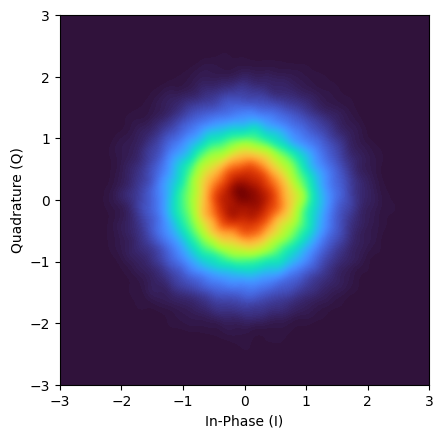

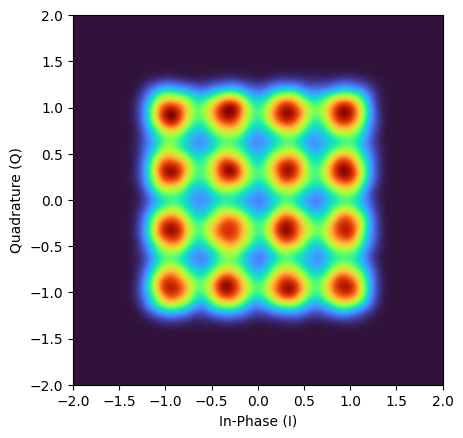

  0%|          | 0/5 [00:00<?, ?it/s]

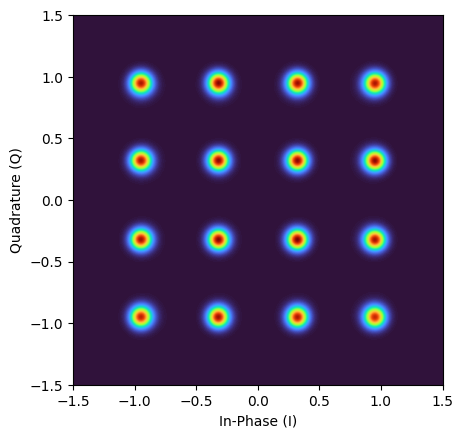

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [41]:
# Matched filtering
if paramTx.pulse == "nrz":
    pulse = pulseShape("nrz", paramADC.SpS_out)
elif paramTx.pulse == "rrc":
    pulse = pulseShape(
        "rrc", paramADC.SpS_out, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1 / paramTx.Rs
    )

pulse = pulse / np.max(np.abs(pulse))
sigRx = firFilter(pulse, sigRx)

# resample to 2 samples/symbol:
paramRes = parameters()
paramRes.Rs = paramTx.Rs
paramRes.SpS_in  = paramADC.SpS_out
paramRes.SpS_out = 2

sigRx = resample(sigRx, paramRes)

# plot constellations after matched filtering
pconst(sigRx[0::paramRes.SpS_out], lim=True, R=3)

# CD compensation
sigRx = edc(sigRx, Ltotal, D, Fc, paramRes.SpS_out*paramTx.Rs)

#plot constellations after CD compensation
pconst(sigRx[0::paramRes.SpS_out], lim=True, R=2)

# Downsampling to 2 sps and re-synchronization with transmitted sequences
sigRx = sigRx.reshape(-1, 1)

symbRx = symbolSync(sigRx, symbTx, 2)

# Power normalization
x = sigRx
d = symbRx

x = x.reshape(len(x), 1) / np.sqrt(signal_power(x))
d = d.reshape(len(d), 1) / np.sqrt(signal_power(d))

# Adaptive equalization
mod = QAMModem(m=paramTx.M)

paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS = 2
paramEq.mu = [5e-3, 2e-3]
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.alg = ["nlms", "dd-lms"]
paramEq.M = paramTx.M
paramEq.L = [20000, 80000]

y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

discard = int(paramEq.L[0]/2)

#plot constellations after adaptive equalization
pconst(y_EQ[discard:-discard,:], lim=True)

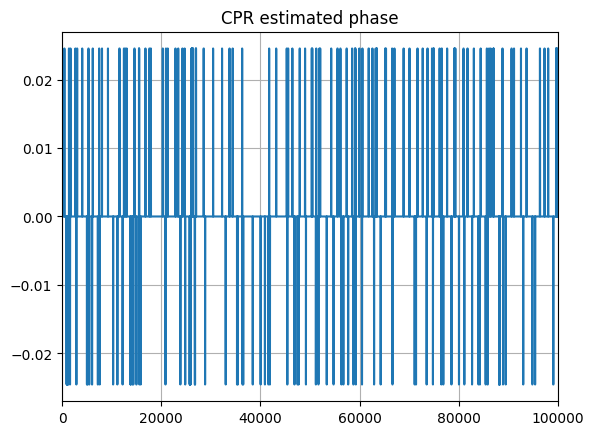

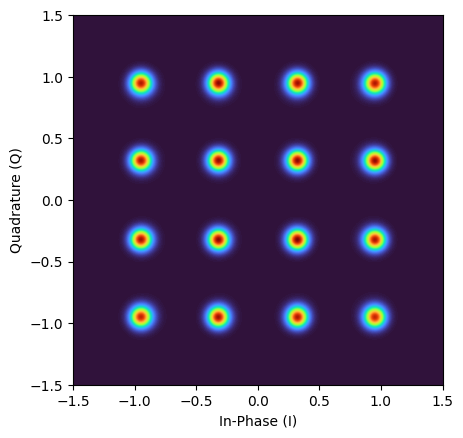

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [42]:
# Carrier phase recovery
paramCPR = parameters()
paramCPR.alg = "bps"
paramCPR.M = paramTx.M
paramCPR.N = 65
paramCPR.B = 64
paramCPR.pilotInd = np.arange(0, len(y_EQ), 20)

y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

plt.figure()
plt.title("CPR estimated phase")
plt.plot(θ, "-")
plt.xlim(0, len(θ))
plt.grid()

discard = 5000

# plot constellations after CPR
pconst(y_CPR[discard:-discard, :], lim=True)

In [43]:
# correct for (possible) phase ambiguity
for k in range(y_CPR.shape[1]):
    rot = np.mean(d[:, k] / y_CPR[:, k])
    y_CPR[:, k] = rot * y_CPR[:, k]

y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

ind = np.arange(discard, d.shape[0] - discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind, :], d[ind, :], paramTx.M, 'qam')
GMI, _ = monteCarloGMI(y_CPR[ind, :], d[ind, :],  paramTx.M, 'qam')
MI = monteCarloMI(y_CPR[ind, :], d[ind, :],  paramTx.M, 'qam')

print("Results:\n")
print("SER: %.2e" % (SER[0]))
print("BER: %.2e" % (BER[0]))
print("SNR: %.2f dB" % (SNR[0]))
print("MI: %.2f bits" % (MI[0]))
print("GMI: %.2f bits" % (GMI[0]));

Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 27.49 dB
MI: 4.00 bits
GMI: 4.00 bits


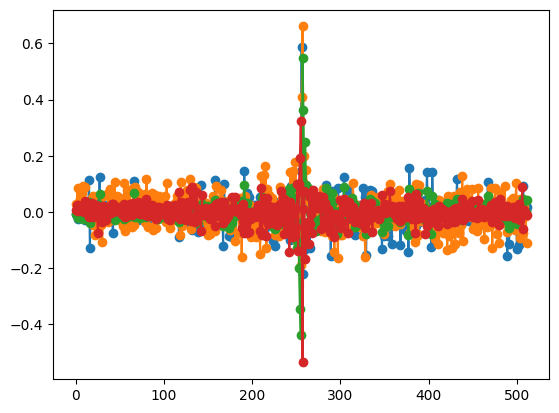

In [44]:
cw1 = model.layers[1].get_weights()
plt.plot(cw1[0],'-o');

In [45]:
## Transmitter parameters:
paramTx = parameters()
paramTx.M = 16                 # order of the modulation format
paramTx.Rs = 32e9              # symbol rate [baud]
paramTx.SpS = 4                # samples per symbol
paramTx.Nbits = 400000         # total number of bits per polarization
paramTx.pulse = "rrc"          # pulse shaping filter
paramTx.Ntaps = 1024           # number of pulse shaping filter coefficients
# paramTx.alphaRRC = 0.9         # RRC rolloff
paramTx.Pch_dBm = 0            # power of the optical signal [dBm]
paramTx.Nch = 1                # number of WDM channels
paramTx.Fc = 193.1e12          # central frequency of the optical spectrum
paramTx.freqSpac = 37.5e9      # WDM grid spacing

## Optical channel parameters:
Ltotal = 100      # total link distance [km]
alpha = 0         # fiber loss parameter [dB/km]
D = 16            # fiber dispersion parameter [ps/nm/km]
Fc = paramTx.Fc   # central optical frequency of the WDM spectrum [Hz]

## Receiver parameters:

# local oscillator (LO)
# FO = 5e9 + paramTx.Rs/2  # frequency offset
lw = 0*200e3       # linewidth
ϕ_lo = 0           # initial phase in rad
Plo_dBm = 12        # power in dBm

# ADC sampling rate
paramADC = parameters()
paramADC.Rs = paramTx.Rs
paramADC.SpS_in = paramTx.SpS
paramADC.SpS_out = 4

## General simulation parameters:
chIndex = 0  # index of the channel to be demodulated
plotPSD = True
Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

# photodiode parameters
paramPD = parameters()
paramPD.B  = 1.1*paramTx.Rs
paramPD.Fs = Fs

In [50]:
path = 'C:/Users/optic/Documents/PIVIC-PIBIC-Comunicacoes-Opticas/setups/NN_models/'
N = 256  # number of input amplitude samples to the NN

Rolloff = np.arange(0.05, 0.95, 0.05)
FO_Values = np.arange(0e9, 6e9, 1e9)

for indexFO, indFO_ in enumerate(tqdm(FO_Values)):
    for indNN, indNN_ in enumerate(tqdm(Rolloff)):
    
        # Main simulation parameters
        paramTx.alphaRRC = indNN_
        FO = indFO_ + paramTx.Rs/2

        # generate optical signal signal
        sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

        # simulate linear signal propagation
        sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)

        # receiver detection and demodulation
        Fc = paramTx.Fc
        Ts = 1 / Fs
        mod = QAMModem(m=paramTx.M)

        freqGrid = paramTx.freqGrid
        print(
            "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
            % (
                chIndex,
                (Fc + freqGrid[chIndex]) / 1e12,
                const.c / (Fc + freqGrid[chIndex]) / 1e-9,
            )
        )

        symbTx = symbTx_[:, :, chIndex]

        Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

        print(
            "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
            % (Plo_dBm, lw / 1e3, FO / 1e6)
        )

        # generate LO field
        π = np.pi
        t = np.arange(0, len(sigCh))*Ts
        ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

        sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

        # Add LO to the received signal
        sigRx = np.sqrt(Plo) + sigCh * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
        sfm = sigRx.copy()

        print('CSPR = %.2f dB' % (10*np.log10(signal_power(sigLO)/signal_power(sigCh))))

        # ### Phase-retrieval stage

        # In[4]:

        # simulate ideal direct-detection optical receiver
        Ipd = photodiode(sigRx, paramPD)
        Amp = np.sqrt(Ipd)
        Amp = resample(Amp, paramADC)

        # resampling to ADC sampling rate
        sigCh = resample(sigCh, paramADC)
        sfm = resample(sfm, paramADC)
        newFs = paramADC.SpS_out*paramTx.Rs

        sfm = sfm/np.sqrt(signal_power(sfm))
        
        sigPhase = np.angle(sfm)  # get signal phase samples (labels) (L,)
        sigAmp = np.pad(Amp, (int(N/2), int(N/2)), 'constant') # get signal amplitude samples (L,)

        # create set of input features
        X_train = np.zeros((len(sigPhase), N))  # (L,N)
        y_train = sigPhase.copy()
        
        for indPhase in range(len(sigPhase)):
            X_train[indPhase] = sigAmp[indPhase:N+indPhase]

        # create set of phase labels
        y_train = np.array([sfm.real, sfm.imag]).T

        # define neural network model
        stop = EarlyStopping(monitor='val_loss', patience=5)
        model = Sequential()
        model.add(BatchNormalization())
        model.add(Dense(4, input_shape=(N,)))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(4, activation='relu'))
        model.add(Dense(2))
        model.compile(optimizer='adam', loss='mse')

        model.fit(X_train, y_train, epochs=100, callbacks=[stop],
            validation_split=0.3, batch_size=256)

        #model.summary()
        model.save(path+'testModel_SpS_'+str(paramADC.SpS_out)+'_FO_'+str(FO/10e9)+'GHz_Rolloff_'+str(round(paramTx.alphaRRC, 2)), save_format='h5')

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB


C:\Users\optic\AppData\Local\Temp\ipykernel_3848\1034019333.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  X_train[indPhase] = sigAmp[indPhase:N+indPhase]


Epoch 1/100
1094/1094 [==============================] - 10s 6ms/step - loss: 0.0222 - val_loss: 0.0012
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0011 - val_loss: 9.5788e-04
Epoch 3/100
1094/1094 [==============================] - 4s 3ms/step - loss: 9.1264e-04 - val_loss: 0.0011
Epoch 4/100
1094/1094 [==============================] - 4s 3ms/step - loss: 7.6858e-04 - val_loss: 5.5844e-04
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.9523e-04 - val_loss: 5.5544e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.5086e-04 - val_loss: 4.8876e-04
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.1228e-04 - val_loss: 5.3030e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.8908e-04 - val_loss: 4.2993e-04
Epoch 9/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.7540e-04 - val_loss: 5.9537e-04
Epoch 10/100
109

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 45s 3ms/step - loss: 0.0788 - val_loss: 0.0012
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0011 - val_loss: 9.2667e-04
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0010 - val_loss: 8.3898e-04
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0010 - val_loss: 7.3508e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 8.9341e-04 - val_loss: 7.2207e-04
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 8.8091e-04 - val_loss: 6.6422e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 8.4620e-04 - val_loss: 6.7637e-04


  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 5s 4ms/step - loss: 0.0278 - val_loss: 0.0019
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0012 - val_loss: 9.9818e-04
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0011 - val_loss: 9.5530e-04
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0011 - val_loss: 9.8322e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 9.8417e-04 - val_loss: 8.9822e-04
Epoch 9/100
1094/

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0252 - val_loss: 0.0018
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.2447 - val_loss: 0.0577
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0342 - val_loss: 0.0198
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0170 - val_loss: 0.0141
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0609 - val_loss: 0.0155
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0154 - val_loss: 0.0153
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0044 - val_loss: 0.0018
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0581 - val_loss: 0.0028
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0207 - val_loss: 0.0022
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0324 - val_loss: 0.0024
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 8s 3ms/step - loss: 0.0217 - val_loss: 0.0026
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0351 - val_loss: 0.0029
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 5s 4ms/step - loss: 0.0536 - val_loss: 0.0156
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0086 - val_loss: 0.0030
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0270 - val_loss: 0.0031
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0319 - val_loss: 0.0035
Epoch 2/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 3/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0354 - val_loss: 0.0038
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0469 - val_loss: 0.0085
Epoch 2/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 12s 8ms/step - loss: 0.0393 - val_loss: 0.0045
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 4/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 9/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0321 - val_loss: 0.0045
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 9/100
1094/1094 [==============

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0223 - val_loss: 0.0012
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 8.7096e-04 - val_loss: 7.0481e-04
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.3273e-04 - val_loss: 4.3236e-04
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 5.4584e-04 - val_loss: 4.3524e-04
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 5.1668e-04 - val_loss: 3.2399e-04
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 5.2039e-04 - val_loss: 3.5425e-04
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 4.7770e-04 - val_loss: 3.4509e-04
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 4.4851e-04 - va

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0292 - val_loss: 9.6969e-04
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 8.5461e-04 - val_loss: 6.8427e-04
Epoch 3/100
1094/1094 [==============================] - 2s 2ms/step - loss: 6.2879e-04 - val_loss: 4.6382e-04
Epoch 4/100
1094/1094 [==============================] - 2s 2ms/step - loss: 5.5898e-04 - val_loss: 5.2672e-04
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 5.2447e-04 - val_loss: 4.7730e-04
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 4.7048e-04 - val_loss: 4.3483e-04
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 4.5429e-04 - val_loss: 3.9345e-04
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 4.0797e-04 

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0819 - val_loss: 0.0153
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0153 - val_loss: 0.0151
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0151 - val_loss: 0.0149
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0060 - val_loss: 4.6258e-04
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 5.6264e-04 - val_loss: 5.9054e-04
Epoch 9/100
1094/1094 [==

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0512 - val_loss: 0.0015
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0010 - val_loss: 9.1038e-04
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 9.5419e-04 - val_loss: 7.6809e-04
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 9.1204e-04 - val_loss: 7.6428e-04
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 8.6996e-04 - val_loss: 7.3996e-04
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 8.3263e-04 - val_loss: 6.8579e-04
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 7.7659e-04 - val_loss: 6.03

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0559 - val_loss: 0.0151
Epoch 2/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0059 - val_loss: 0.0012
Epoch 3/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0012 - val_loss: 8.8582e-04
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0010 - val_loss: 8.8944e-04
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 9.5938e-04 - val_loss: 8.1507e-04
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 9.1978e-04 - val_loss: 7.4098e-04
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 8.8968e-04 - val_loss: 7.1819e-04
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 8.7539e-04 - val_loss: 7.7151e-

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0319 - val_loss: 0.0018
Epoch 2/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 3/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 4/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0012 - val_loss: 9.9716e-04
Epoch 9/100
1094/1094 [==========

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0853 - val_loss: 0.0155
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0154 - val_loss: 0.0155
Epoch 3/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 4/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0119 - val_loss: 0.0014
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 116s 3ms/step - loss: 0.0323 - val_loss: 0.0019
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/100
1094/1094 [============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0751 - val_loss: 0.0152
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0065 - val_loss: 0.0018
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0386 - val_loss: 0.0022
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0531 - val_loss: 0.0154
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0154 - val_loss: 0.0152
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 4/100
1094/1094 [==============================] - 5s 4ms/step - loss: 0.0153 - val_loss: 0.0151
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0326 - val_loss: 0.0033
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0404 - val_loss: 0.0031
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0263 - val_loss: 0.0029
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0569 - val_loss: 0.0157
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0133 - val_loss: 0.0039
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0313 - val_loss: 0.0032
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0239 - val_loss: 0.0036
Epoch 2/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 3/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 4/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0344 - val_loss: 0.0037
Epoch 2/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 3/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 4/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 9/100
1094/1094 [==============

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1030 - val_loss: 0.0152
Epoch 2/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0027 - val_loss: 7.1906e-04
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 6.2588e-04 - val_loss: 4.1911e-04
Epoch 4/100
1094/1094 [==============================] - 2s 2ms/step - loss: 5.1186e-04 - val_loss: 9.0109e-04
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 4.4656e-04 - val_loss: 2.9306e-04
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 4.0008e-04 - val_loss: 2.2852e-04
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 3.8502e-04 - val_loss: 2.5615e-04
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 3.7088e-04 - val_lo

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 5s 3ms/step - loss: 0.0284 - val_loss: 0.0013
Epoch 2/100
1094/1094 [==============================] - 2s 2ms/step - loss: 8.4430e-04 - val_loss: 7.6997e-04
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 6.6066e-04 - val_loss: 4.6815e-04
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.7090e-04 - val_loss: 3.5487e-04
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 5.3119e-04 - val_loss: 3.6707e-04
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 4.7590e-04 - val_loss: 2.5600e-04
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 4.1784e-04 - val_loss: 2.1470e-04
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 3.9229e-04 - va

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 10s 6ms/step - loss: 0.0178 - val_loss: 9.1258e-04
Epoch 2/100
1094/1094 [==============================] - 2s 2ms/step - loss: 7.8329e-04 - val_loss: 5.6366e-04
Epoch 3/100
1094/1094 [==============================] - 2s 2ms/step - loss: 5.8849e-04 - val_loss: 3.8014e-04
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 5.0399e-04 - val_loss: 3.6602e-04
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 4.3778e-04 - val_loss: 3.0250e-04
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 4.0808e-04 - val_loss: 2.7236e-04
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 3.8374e-04 - val_loss: 4.3336e-04
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 3.5963e-04

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 5s 3ms/step - loss: 0.0295 - val_loss: 7.3039e-04
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 7.8657e-04 - val_loss: 5.9380e-04
Epoch 3/100
1094/1094 [==============================] - 2s 2ms/step - loss: 6.5694e-04 - val_loss: 4.8268e-04
Epoch 4/100
1094/1094 [==============================] - 2s 2ms/step - loss: 5.9260e-04 - val_loss: 5.0299e-04
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 5.6516e-04 - val_loss: 3.9453e-04
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 5.5161e-04 - val_loss: 4.1944e-04
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 5.1384e-04 - val_loss: 3.2751e-04
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 4.8098e-04 

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.2021 - val_loss: 0.0507
Epoch 2/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0340 - val_loss: 0.0298
Epoch 3/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0298 - val_loss: 0.0297
Epoch 4/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0069 - val_loss: 0.0015
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0011 - val_loss: 7.0813e-04
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 8.3425e-04 - val_loss: 6.2460e-04
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 7.7113e-04 - val_loss: 5.8606e-04
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 7.4743e-04 - val_loss: 5.5197e-04
Epoch 9/1

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 5s 3ms/step - loss: 0.0217 - val_loss: 0.0014
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0011 - val_loss: 7.6007e-04
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 8.3983e-04 - val_loss: 6.3090e-04
Epoch 4/100
1094/1094 [==============================] - 2s 2ms/step - loss: 7.6710e-04 - val_loss: 5.4164e-04
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 6.9674e-04 - val_loss: 5.0964e-04
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 6.6015e-04 - val_loss: 4.7390e-04
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 6.0641e-04 - val_loss: 4.3219e-04
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 5.7524e-04 - val_lo

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0472 - val_loss: 0.0024
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0010 - val_loss: 9.8852e-04
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 9.5528e-04 - val_loss: 8.5953e-04
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 9.0831e-04 - val_loss: 7.0828e-04
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 8.3295e-04 - val_loss: 7.2080e-04
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 8.0618e-04 - val_loss: 6.5240e-04
E

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.2070 - val_loss: 0.0516
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0218 - val_loss: 0.0025
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0011 - val_loss: 9.9663e-04
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0011 - val_loss: 9.5898e-04
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0011 - val_loss: 9.4609e-04
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0010 - val_loss: 9.0112e-04
Epoch 9/100
1094/1094

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0255 - val_loss: 0.0016
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0012 - val_loss: 9.5955e-04
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0012 - val_loss: 9.4569e-04
Epoch 9/100
1094/1094 [======

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 20s 18ms/step - loss: 0.0311 - val_loss: 0.0022
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 4/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 9/100
1094/1094 [============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 6s 4ms/step - loss: 0.0479 - val_loss: 0.0155
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0155 - val_loss: 0.0153
Epoch 3/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0154 - val_loss: 0.0153
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0154 - val_loss: 0.0153
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0152 - val_loss: 0.0150
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0151 - val_loss: 0.0150
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 9s 7ms/step - loss: 0.0297 - val_loss: 0.0155
Epoch 2/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 3/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 4/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0152 - val_loss: 0.0153
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0152 - val_loss: 0.0153
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 5s 4ms/step - loss: 0.0248 - val_loss: 0.0023
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 177s 4ms/step - loss: 0.0435 - val_loss: 0.0156
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0090 - val_loss: 0.0023
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 9/100
1094/1094 [============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0532 - val_loss: 0.0156
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0156 - val_loss: 0.0155
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0122 - val_loss: 0.0024
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0434 - val_loss: 0.0026
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0236 - val_loss: 0.0028
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0203 - val_loss: 0.0030
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 9/100
1094/1094 [==============

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0229 - val_loss: 0.0012
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 8.5626e-04 - val_loss: 6.5112e-04
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.5908e-04 - val_loss: 5.0735e-04
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.7029e-04 - val_loss: 3.8784e-04
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.6687e-04 - val_loss: 3.0011e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.4145e-04 - val_loss: 3.7144e-04
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 3.9976e-04 - val_loss: 2.1888e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 3.6016e-04 - va

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0271 - val_loss: 0.0027
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 6.9146e-04 - val_loss: 5.9600e-04
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 5.8120e-04 - val_loss: 3.7575e-04
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 5.0975e-04 - val_loss: 3.1592e-04
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 4.4862e-04 - val_loss: 2.8284e-04
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 4.2097e-04 - val_loss: 2.6149e-04
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 3.8153e-04 - val_loss: 

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0272 - val_loss: 0.0034
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 7.3206e-04 - val_loss: 9.3009e-04
Epoch 4/100
1094/1094 [==============================] - 2s 2ms/step - loss: 5.8479e-04 - val_loss: 5.3174e-04
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 5.1403e-04 - val_loss: 4.4810e-04
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 4.6613e-04 - val_loss: 3.4126e-04
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 4.1418e-04 - val_loss: 2.3988e-04
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 3.9149e-04 - val_loss: 

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0532 - val_loss: 0.0019
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 9.8295e-04 - val_loss: 8.8632e-04
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 7.1976e-04 - val_loss: 6.6429e-04
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 5.7651e-04 - val_loss: 4.7495e-04
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 4.8966e-04 - val_loss: 5.5572e-04
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 4.5494e-04 - val_loss: 5.2442e-04
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 4.2652e-04 - val_loss: 5.2255e-04
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 3.9966e-04 - va

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0438 - val_loss: 0.0015
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0012 - val_loss: 7.6573e-04
Epoch 3/100
1094/1094 [==============================] - 2s 2ms/step - loss: 8.2725e-04 - val_loss: 5.8464e-04
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 7.2667e-04 - val_loss: 6.4162e-04
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 6.5567e-04 - val_loss: 4.5602e-04
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 6.0824e-04 - val_loss: 4.3681e-04
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 5.7120e-04 - val_loss: 6.7248e-04
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 5.3080e-04 - val_lo

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 5s 4ms/step - loss: 0.0789 - val_loss: 0.0156
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0155 - val_loss: 0.0153
Epoch 3/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0153 - val_loss: 0.0154
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0152 - val_loss: 0.0150
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 5s 3ms/step - loss: 0.0204 - val_loss: 0.0011
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0010 - val_loss: 9.3048e-04
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 8.7090e-04 - val_loss: 6.1096e-04
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 7.8564e-04 - val_loss: 6.8399e-04
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 6.7639e-04 - val_loss: 7.4423e-04
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 6.5376e-04 - val_loss: 5.3347e-04
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 5.9093e-04 - val_loss: 6.4194e-04
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 5.7807e-04 - val_lo

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 8s 3ms/step - loss: 0.0283 - val_loss: 0.0015
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0012 - val_loss: 8.6322e-04
Epoch 3/100
1094/1094 [==============================] - 2s 2ms/step - loss: 9.4175e-04 - val_loss: 8.3267e-04
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 8.3193e-04 - val_loss: 7.2875e-04
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 7.4625e-04 - val_loss: 5.3623e-04
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 7.1543e-04 - val_loss: 5.5224e-04
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 6.8272e-04 - val_loss: 5.1523e-04
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 6.5296e-04 - val_lo

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 20s 15ms/step - loss: 0.0241 - val_loss: 0.0014
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0011 - val_loss: 8.7831e-04
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 9.6014e-04 - val_loss: 7.3321e-04
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 9.0284e-04 - val_loss: 7.9594e-04
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 8.5039e-04 - val_loss: 6.5269e-04
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 8.2448e-04 - val_loss: 6.5916e-04
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 8.1484e-04 - val_loss: 6.

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 8s 4ms/step - loss: 0.0256 - val_loss: 0.0015
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0011 - val_loss: 9.5167e-04
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0010 - val_loss: 7.8452e-04
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 9.2667e-04 - val_loss: 7.3960e-04
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 8.8987e-04 - val_loss: 7.0755e-04
Epoch 9/100
1

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 14s 4ms/step - loss: 0.0434 - val_loss: 0.0155
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 3/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 4/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0121 - val_loss: 0.0012
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 9/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 28s 5ms/step - loss: 0.0418 - val_loss: 0.0019
Epoch 2/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 4/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 9/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 9s 3ms/step - loss: 0.0719 - val_loss: 0.0022
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 3/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 7/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 11s 5ms/step - loss: 0.0247 - val_loss: 0.0019
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 4/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 7/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 25s 4ms/step - loss: 0.0249 - val_loss: 0.0021
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 5s 3ms/step - loss: 0.0499 - val_loss: 0.0025
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 4/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 5/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 6/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 25s 10ms/step - loss: 0.0249 - val_loss: 0.0026
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 9/100
1094/1094 [============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 7s 3ms/step - loss: 0.0524 - val_loss: 0.0157
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0063 - val_loss: 0.0029
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 9/100
1094/1094 [==============

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 6s 3ms/step - loss: 0.0171 - val_loss: 0.0013
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 9.1673e-04 - val_loss: 6.6584e-04
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 6.5796e-04 - val_loss: 4.5452e-04
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 5.2672e-04 - val_loss: 4.3771e-04
Epoch 5/100
1094/1094 [==============================] - 3s 2ms/step - loss: 4.6158e-04 - val_loss: 4.3322e-04
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 4.3831e-04 - val_loss: 3.2723e-04
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 4.0430e-04 - val_loss: 2.9620e-04
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 3.7687e-04 - va

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 9s 8ms/step - loss: 0.1970 - val_loss: 0.0495
Epoch 2/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0222 - val_loss: 0.0152
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0054 - val_loss: 8.1701e-04
Epoch 4/100
1094/1094 [==============================] - 3s 2ms/step - loss: 6.0317e-04 - val_loss: 5.9939e-04
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.5803e-04 - val_loss: 4.3172e-04
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 5.0423e-04 - val_loss: 3.1036e-04
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 4.1489e-04 - val_loss: 3.4880e-04
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 3.7183e-04 - val_loss: 1.95

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 152s 4ms/step - loss: 0.0380 - val_loss: 0.0153
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0030 - val_loss: 8.7315e-04
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.3915e-04 - val_loss: 4.7759e-04
Epoch 4/100
1094/1094 [==============================] - 4s 3ms/step - loss: 5.0688e-04 - val_loss: 5.0467e-04
Epoch 5/100
1094/1094 [==============================] - 4s 3ms/step - loss: 4.3816e-04 - val_loss: 3.1025e-04
Epoch 6/100
1094/1094 [==============================] - 4s 3ms/step - loss: 4.0337e-04 - val_loss: 2.6021e-04
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 3.7240e-04 - val_loss: 2.4668e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 3.5845e-04 - val_

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0259 - val_loss: 0.0015
Epoch 2/100
1094/1094 [==============================] - 4s 3ms/step - loss: 8.7751e-04 - val_loss: 9.0386e-04
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.8009e-04 - val_loss: 7.2070e-04
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.5584e-04 - val_loss: 4.6735e-04
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.1777e-04 - val_loss: 5.5345e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.4891e-04 - val_loss: 4.1687e-04
Epoch 7/100
1094/1094 [==============================] - 4s 3ms/step - loss: 4.0309e-04 - val_loss: 4.0067e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 3.6164e-04 - va

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0213 - val_loss: 9.8028e-04
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 8.7453e-04 - val_loss: 6.0842e-04
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 7.1543e-04 - val_loss: 6.3012e-04
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.3419e-04 - val_loss: 4.3885e-04
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.8711e-04 - val_loss: 3.8036e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.5433e-04 - val_loss: 5.6767e-04
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.5877e-04 - val_loss: 3.5468e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.2550e-04 

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0340 - val_loss: 0.0025
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0011 - val_loss: 6.0092e-04
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.8972e-04 - val_loss: 5.0440e-04
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.1625e-04 - val_loss: 4.2701e-04
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.6088e-04 - val_loss: 3.6594e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.7532e-04 - val_loss: 4.0083e-04
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.5015e-04 - val_loss: 2.9708e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.4507e-04 - val_lo

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 5s 4ms/step - loss: 0.0231 - val_loss: 0.0012
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0010 - val_loss: 7.2579e-04
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 7.8689e-04 - val_loss: 5.2796e-04
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.7344e-04 - val_loss: 6.0692e-04
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.9680e-04 - val_loss: 4.5193e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.7002e-04 - val_loss: 3.6438e-04
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.4336e-04 - val_loss: 3.5448e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.1003e-04 - val_lo

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0248 - val_loss: 0.0011
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0010 - val_loss: 8.1479e-04
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 7.8807e-04 - val_loss: 5.7210e-04
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.7250e-04 - val_loss: 5.1787e-04
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.9525e-04 - val_loss: 3.6442e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.5149e-04 - val_loss: 4.1190e-04
Epoch 7/100
1094/1094 [==============================] - 4s 3ms/step - loss: 5.1437e-04 - val_loss: 3.2925e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.7874e-04 - val_lo

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0337 - val_loss: 0.0015
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 9.4561e-04 - val_loss: 7.6591e-04
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 8.8942e-04 - val_loss: 7.7791e-04
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 8.2762e-04 - val_loss: 7.7724e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 8.0872e-04 - val_loss: 7.7291e-04
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 8.0886e-04 - val_loss: 7.1351e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 7.9417e-04 - val_loss: 

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 5s 4ms/step - loss: 0.0345 - val_loss: 0.0012
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0011 - val_loss: 8.4332e-04
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 9.6870e-04 - val_loss: 8.5541e-04
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 8.6154e-04 - val_loss: 7.5254e-04
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 7.7494e-04 - val_loss: 5.5991e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 7.3011e-04 - val_loss: 6.8970e-04
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.7283e-04 - val_loss: 5.1866e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.5160e-04 - val_lo

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0469 - val_loss: 0.0155
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0146 - val_loss: 0.0027
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0012 - val_loss: 9.9457e-04
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0010 - val_loss: 8.1511e-04
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 9.3814e-04 - val_loss: 7.1302e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 8.7830e-04 - val_loss: 6.6343e-04
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 8.0470e-04 - val_loss: 5.9966e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 7.9535e-04 - val_loss: 7.0314e-

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 6s 4ms/step - loss: 0.0250 - val_loss: 0.0025
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 9.9329e-04 - val_loss: 9.0592e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 9.5425e-04 - val_loss: 8.0682e-04
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 9.0790e-04 - val_loss: 8.0629e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 8.9669e-04 - val_loss: 8.1125e-04
Epoch

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 5s 3ms/step - loss: 0.0497 - val_loss: 0.0041
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0011 - val_loss: 9.5366e-04
Epoch 9/100
1094/1094 [==========

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 11s 6ms/step - loss: 0.0253 - val_loss: 0.0020
Epoch 2/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 21s 5ms/step - loss: 0.0253 - val_loss: 0.0017
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 3/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 9/100
1094/1094 [=============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 7s 4ms/step - loss: 0.0538 - val_loss: 0.0022
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 9s 4ms/step - loss: 0.0436 - val_loss: 0.0027
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 7s 4ms/step - loss: 0.0280 - val_loss: 0.0055
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 9/100
1094/1094 [==============

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 13s 4ms/step - loss: 0.2259 - val_loss: 0.0547
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0352 - val_loss: 0.0297
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0160 - val_loss: 0.0034
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.9395e-04 - val_loss: 5.5915e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.9132e-04 - val_loss: 7.2490e-04
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.2993e-04 - val_loss: 3.1889e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 3.9571e-04 - val_loss: 2.5548e-04
Epoc

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 7s 4ms/step - loss: 0.0278 - val_loss: 0.0012
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 7.3261e-04 - val_loss: 7.0425e-04
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.7723e-04 - val_loss: 5.8472e-04
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.9519e-04 - val_loss: 5.1965e-04
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.7572e-04 - val_loss: 4.6450e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.4586e-04 - val_loss: 3.1934e-04
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.0702e-04 - val_loss: 4.0874e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 3.9138e-04 - va

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 12s 7ms/step - loss: 0.0289 - val_loss: 0.0014
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 8.7570e-04 - val_loss: 7.6301e-04
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.0883e-04 - val_loss: 5.3193e-04
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.8289e-04 - val_loss: 3.0597e-04
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.3263e-04 - val_loss: 4.2967e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 3.8384e-04 - val_loss: 2.5619e-04
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 3.7141e-04 - val_loss: 1.8893e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 3.5702e-04 - v

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 16s 11ms/step - loss: 0.0162 - val_loss: 9.6874e-04
Epoch 2/100
1094/1094 [==============================] - 5s 4ms/step - loss: 7.4262e-04 - val_loss: 5.5936e-04
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.5574e-04 - val_loss: 4.3432e-04
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.6645e-04 - val_loss: 3.7339e-04
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.1966e-04 - val_loss: 2.9483e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 3.9209e-04 - val_loss: 2.6750e-04
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 3.7153e-04 - val_loss: 2.5117e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 3.4720e-0

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 8s 5ms/step - loss: 0.0216 - val_loss: 0.0010
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 8.4449e-04 - val_loss: 5.3928e-04
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.0750e-04 - val_loss: 4.6392e-04
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.3221e-04 - val_loss: 3.9491e-04
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.8432e-04 - val_loss: 3.3845e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.5124e-04 - val_loss: 2.6402e-04
Epoch 7/100
1094/1094 [==============================] - 4s 3ms/step - loss: 4.3459e-04 - val_loss: 2.2056e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 3.9127e-04 - va

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 10s 5ms/step - loss: 0.0265 - val_loss: 0.0017
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 9.8735e-04 - val_loss: 0.0011
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 7.7606e-04 - val_loss: 8.6885e-04
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.6743e-04 - val_loss: 6.5895e-04
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.1975e-04 - val_loss: 4.5023e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.3832e-04 - val_loss: 3.5755e-04
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.7319e-04 - val_loss: 3.6747e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.5158e-04 - val_l

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 6s 4ms/step - loss: 0.0206 - val_loss: 0.0012
Epoch 2/100
1094/1094 [==============================] - 4s 3ms/step - loss: 8.9906e-04 - val_loss: 9.6056e-04
Epoch 3/100
1094/1094 [==============================] - 4s 3ms/step - loss: 7.4000e-04 - val_loss: 5.8599e-04
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.5152e-04 - val_loss: 6.2368e-04
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.9563e-04 - val_loss: 4.5867e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.1329e-04 - val_loss: 3.8385e-04
Epoch 7/100
1094/1094 [==============================] - 4s 4ms/step - loss: 4.4709e-04 - val_loss: 3.1861e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 3.8629e-04 - va

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 8s 5ms/step - loss: 0.0203 - val_loss: 0.0015
Epoch 2/100
1094/1094 [==============================] - 4s 3ms/step - loss: 9.0775e-04 - val_loss: 5.6529e-04
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 6.6114e-04 - val_loss: 4.0199e-04
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 5.5552e-04 - val_loss: 3.7896e-04
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.5598e-04 - val_loss: 2.5375e-04
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 4.2068e-04 - val_loss: 2.5249e-04
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 3.9198e-04 - val_loss: 2.0578e-04
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 3.6899e-04 - va

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 125s 113ms/step - loss: 0.0323 - val_loss: 9.6738e-04
Epoch 2/100
1094/1094 [==============================] - 4s 4ms/step - loss: 9.0074e-04 - val_loss: 8.4200e-04
Epoch 3/100
1094/1094 [==============================] - 4s 4ms/step - loss: 7.2134e-04 - val_loss: 5.4984e-04
Epoch 4/100
1094/1094 [==============================] - 4s 3ms/step - loss: 6.2912e-04 - val_loss: 4.0206e-04
Epoch 5/100
1094/1094 [==============================] - 4s 4ms/step - loss: 5.3767e-04 - val_loss: 6.5499e-04
Epoch 6/100
1094/1094 [==============================] - 4s 3ms/step - loss: 5.0701e-04 - val_loss: 3.1764e-04
Epoch 7/100
1094/1094 [==============================] - 4s 3ms/step - loss: 4.6852e-04 - val_loss: 3.6218e-04
Epoch 8/100
1094/1094 [==============================] - 4s 4ms/step - loss: 4.4665e

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 5s 4ms/step - loss: 0.2063 - val_loss: 0.0520
Epoch 2/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0340 - val_loss: 0.0304
Epoch 3/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0257 - val_loss: 0.0166
Epoch 4/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0154 - val_loss: 0.0160
Epoch 5/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0153 - val_loss: 0.0158
Epoch 6/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0152 - val_loss: 0.0154
Epoch 7/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0055 - val_loss: 5.0587e-04
Epoch 8/100
1094/1094 [==============================] - 4s 4ms/step - loss: 5.8935e-04 - val_loss: 4.1106e-04
Epoch 9/100
1094/1094 [==

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 5s 4ms/step - loss: 0.0293 - val_loss: 0.0012
Epoch 2/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0011 - val_loss: 7.9256e-04
Epoch 3/100
1094/1094 [==============================] - 4s 3ms/step - loss: 8.8763e-04 - val_loss: 6.9713e-04
Epoch 4/100
1094/1094 [==============================] - 4s 3ms/step - loss: 8.0783e-04 - val_loss: 5.7345e-04
Epoch 5/100
1094/1094 [==============================] - 4s 3ms/step - loss: 7.3557e-04 - val_loss: 9.7306e-04
Epoch 6/100
1094/1094 [==============================] - 4s 4ms/step - loss: 6.7623e-04 - val_loss: 5.3036e-04
Epoch 7/100
1094/1094 [==============================] - 4s 3ms/step - loss: 6.6716e-04 - val_loss: 4.5978e-04
Epoch 8/100
1094/1094 [==============================] - 4s 4ms/step - loss: 6.5343e-04 - val_lo

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 5s 4ms/step - loss: 0.0410 - val_loss: 0.0161
Epoch 2/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0155 - val_loss: 0.0158
Epoch 3/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0153 - val_loss: 0.0158
Epoch 4/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0152 - val_loss: 0.0157
Epoch 5/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0152 - val_loss: 0.0156
Epoch 6/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0152 - val_loss: 0.0155
Epoch 7/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0151 - val_loss: 0.0152
Epoch 8/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0151 - val_loss: 0.0151
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 5s 4ms/step - loss: 0.0233 - val_loss: 0.0013
Epoch 2/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 3/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0011 - val_loss: 8.3474e-04
Epoch 4/100
1094/1094 [==============================] - 4s 3ms/step - loss: 9.5711e-04 - val_loss: 8.8630e-04
Epoch 5/100
1094/1094 [==============================] - 4s 3ms/step - loss: 8.8171e-04 - val_loss: 6.9500e-04
Epoch 6/100
1094/1094 [==============================] - 4s 3ms/step - loss: 8.5015e-04 - val_loss: 7.6235e-04
Epoch 7/100
1094/1094 [==============================] - 4s 3ms/step - loss: 8.2420e-04 - val_loss: 6.2310e-04
Epoch 8/100
1094/1094 [==============================] - 4s 3ms/step - loss: 8.1164e-04 - val_loss: 6.38

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 5s 4ms/step - loss: 0.0217 - val_loss: 0.0014
Epoch 2/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 3/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0011 - val_loss: 8.9706e-04
Epoch 4/100
1094/1094 [==============================] - 4s 3ms/step - loss: 9.7683e-04 - val_loss: 8.0638e-04
Epoch 5/100
1094/1094 [==============================] - 4s 3ms/step - loss: 9.5936e-04 - val_loss: 7.6681e-04
Epoch 6/100
1094/1094 [==============================] - 4s 3ms/step - loss: 9.1771e-04 - val_loss: 7.7422e-04
Epoch 7/100
1094/1094 [==============================] - 4s 3ms/step - loss: 9.0095e-04 - val_loss: 7.7711e-04
Epoch 8/100
1094/1094 [==============================] - 4s 3ms/step - loss: 8.6145e-04 - val_loss: 8.08

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 5s 4ms/step - loss: 0.0317 - val_loss: 0.0017
Epoch 2/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 4/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0011 - val_loss: 9.7214e-04
Epoch 7/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0011 - val_loss: 9.1450e-04
Epoch 8/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0011 - val_loss: 9.6249e-04
Epoch 9/100
1094/1094 [==

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0318 - val_loss: 0.0020
Epoch 2/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 3/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 4/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 5s 4ms/step - loss: 0.0334 - val_loss: 0.0021
Epoch 2/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 4/100
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 9/100
1094/1094 [==============

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 5s 4ms/step - loss: 0.0233 - val_loss: 0.0019
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 3/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 6/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 7/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 8/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/100
1094/1094 [==============